# My Deep Learning Framework

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Labels
- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [85]:
articles = {
            0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
            5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

def get_article(id):
    return articles.get(id)

## Loading Fashion MNIST data

### Working with pandas and numpy

In [86]:
base_data_path = 'fashion-mnist-data'
df = pd.read_csv(f'./{base_data_path}/fashion-mnist_train.csv')
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Building the Neural Network

In [118]:
def init_params(batch_size: int, layers_neurons: list):
    W1 = np.random.randn(layers_neurons[0], batch_size)
    b1 = np.zeros(shape=(1, batch_size))

    W2 = np.random.randn(batch_size, layers_neurons[1])
    b2 = np.zeros(shape=(1, layers_neurons[1]))

    W3 = np.random.randn(layers_neurons[1], layers_neurons[2])
    b3 = np.zeros(shape=(1, layers_neurons[2]))
    
    return W1, b1, W2, b2, W3, b3

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    z = x - np.max(x, axis=1, keepdims=True)
    probs = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    return probs

def cross_entropy_loss(y_pred, y_true_one_hot):

    epsilon = 1e-10  # Small constant to avoid log(0)
    #Clip predicted probabilities to avoid log(0) or log(1)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    # Calculate cross-entropy loss
    loss = -np.sum(y_true_one_hot * np.log(y_pred)) / len(y_true_one_hot)
    return loss

def relu_prime(z):
    #z[ z <= 0] = 0
    return z > 0

def one_hot(y, k=10):
    #one_hot_y = np.zeros(shape=(y.size, k))
    #classes = np.arange(y.size)
    #one_hot_y[classes, y] = 1
    one_hot_y = np.zeros((y.size, 10)) # 10 classes
    one_hot_y[np.arange(y.size), y] = 1
    return one_hot_y

def forward_propagation(X, W1, b1, W2, b2, W3, b3):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = relu(Z2)
    Z3 = np.dot(A2, W3) + b3
    A3 = softmax(Z3)

    #print("A1",A1.shape)
    #print("A2",A2.shape)
    #print("A3",A3.shape)
    
    return Z1, A1, Z2, A2, Z3, A3

def back_propagation(learning_rate, X, Y_one_hot, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3):
    size = len(Y_one_hot) # batch samples (100)

    dZ3_output_error = A3 - Y_one_hot #100,10
    dW3_hidden = np.dot(A2.T, dZ3_output_error) / size
    db3_hidden = np.sum(dZ3_output_error) / size

    dA2_hidden = np.dot(dZ3_output_error, W3.T) 
    dZ2_hidden_error = dA2_hidden * relu_prime(Z2)
    dW2_hidden = np.dot(A1.T, dZ2_hidden_error) / size
    db2_hidden = np.sum(dZ2_hidden_error) / size

    dA1_hidden = np.dot(dZ2_hidden_error, W2.T)
    dZ1_hidden_error = dA1_hidden * relu_prime(Z1)
    dW1_hidden = np.dot(X.T, dZ1_hidden_error) / size
    db1_hidden = np.sum(dZ1_hidden_error, 1) / size


    W3 -= learning_rate * dW3_hidden
    W2 -= learning_rate * dW2_hidden
    W1 -= learning_rate * dW1_hidden
    b3 -= learning_rate * db3_hidden
    b2 -= learning_rate * db2_hidden
    b1 -= learning_rate * db1_hidden
    
    #return dW1, db1, dW2, db2, dW3, db3
    return W1, W2, W3, b1, b2, b3


In [119]:
TEST_SAMPLES = 1000
N_FEATURES = 784

data = np.array(df)
m, n = data.shape # 60000, 785 
np.random.shuffle(data)

X_test = data[0:TEST_SAMPLES, 1:] # (1000, 784)
Y_test = data[0:TEST_SAMPLES, 0] # (1000,)

X_train = data[TEST_SAMPLES:, 1:] # (59000, 784)
Y_train = data[TEST_SAMPLES:, 0] # (59000,)

# Normalization
X_test = X_test / 255
X_train = X_train / 255

In [120]:
print(X_test.shape)
print(Y_test.shape)
print(X_train.shape)
print(Y_train.shape)

(1000, 784)
(1000,)
(59000, 784)
(59000,)


Creating a Neural Network with:
- 3 layers: 1 input, 1 hidden, 1 output
- hidden layer

In [121]:
# Hyperparams
batch_size = 100
epochs = 300
learning_rate = 0.05

layers_neurons = [784, 25, 10]
total_samples = len(Y_train)
loss_history = []

def train():

    W1, b1, W2, b2, W3, b3 = init_params(batch_size, layers_neurons)

    for epoch in range(epochs):
        total_loss = 0
        for i in range(0, total_samples, batch_size):
            X_batch = X_train[i: i + batch_size, :]
            Y_batch = Y_train[i: i + batch_size ]


            Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X_batch, W1, b1, W2, b2, W3, b3)
            y_one_hot = one_hot(Y_batch) # (100, 10)
            loss = cross_entropy_loss(y_pred=A3, y_true_one_hot=y_one_hot) 

            total_loss += loss

            W1, W2, W3, b1, b2, b3 = back_propagation(learning_rate,X_batch,y_one_hot, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3)
        

        if epoch == 0 or (epoch + 1) % 50  == 0:
            #acc = get_accuracy(A3, Y)
            print(f"Epoc: {epoch + 1}, loss: {round(loss,4)}")
            #break
        avg_loss = total_loss / (total_samples / batch_size)
        loss_history.append(avg_loss)
            
    return W1, b1, W2, b2, W3, b3
    
W1, b1, W2, b2, W3, b3 = train()

Epoc: 1, loss: 2.1964
Epoc: 50, loss: 1.8645
Epoc: 100, loss: 1.8061
Epoc: 150, loss: 1.7816
Epoc: 200, loss: 1.7581
Epoc: 250, loss: 1.7446
Epoc: 300, loss: 1.7386


#### Analyzing Epochs and Loss

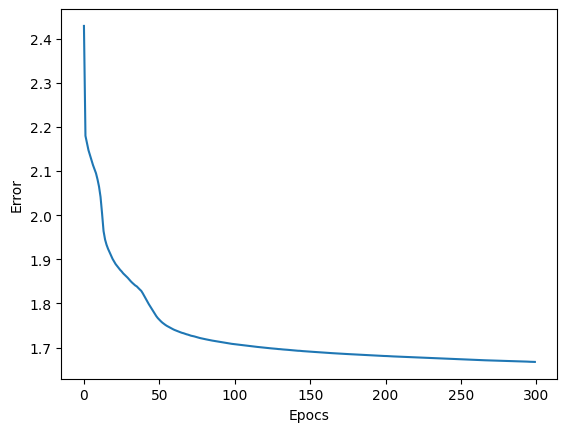

In [122]:
import matplotlib.pyplot as plt
plt.xlabel('Epocs')
plt.ylabel('Error')
plt.plot(loss_history)

## Inferences

In [131]:
X_test.shape
X_test[10,np.newaxis, :].shape 

(1, 784)

In [136]:
random_item = 0
Y_item_test = Y_test[random_item]
X_item_test = X_test[random_item,np.newaxis, :] 

Y_item_test, get_article(Y_item_test)

(5, 'Sandal')

In [142]:
def predict(index, X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_propagation(X, W1, b1, W2, b2, W3, b3)
    predictions = np.argmax(A3, axis=1)
    return predictions #[index]

item_predicted = predict(random_item, X_item_test, W1, b1, W2, b2, W3, b3)
item_predicted, get_article(item_predicted[0])

(array([5]), 'Sandal')

#### Actual Image

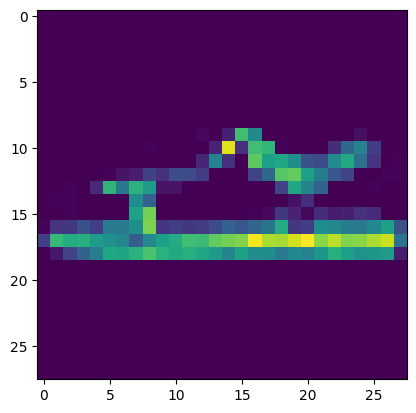

In [143]:
img = X_item_test.reshape((28, 28)) * 255
plt.imshow(img)
plt.show()